In [5]:
import pandas as pd
import numpy as np
import os, shutil, zipfile

def load_and_stack_data(zip_path):
    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data/extracted')

    # Get a list of all CSV files in the extracted folder and concatenate into one DataFrame
    csv_files = [os.path.join('data/extracted', file) for file in os.listdir('data/extracted') if file.endswith('.csv')]
    dataframes = [pd.read_csv(csv, low_memory=False) for csv in sorted(csv_files)]
    shutil.rmtree('data/extracted')
    
    return pd.concat(dataframes, ignore_index=True)

In [17]:
# Path to the zip file
gen_path = 'data\generation.zip'
load_path = 'data\load.zip'
market_path = 'data\market.zip'
prices_path = 'data\prices.zip'

gen_data = load_and_stack_data(gen_path)
load_data = load_and_stack_data(load_path)
market_data = load_and_stack_data(market_path)
prices_data = load_and_stack_data(prices_path)

In [18]:
def enforce_hourly_granularity(df, value_columns):
    """
    Enforces hourly granularity on dataframe with 'MTU (UTC)' time intervals.
    
    - Leaves hourly data unchanged (1 hour intervals)
    - Averages sub-hourly data (15-min, 30-min intervals) into 1-hour blocks
    - Handles both input formats (with/without seconds)
    - Output format: "DD/MM/YYYY HH:MM - DD/MM/YYYY HH:MM" (no seconds)
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'MTU (UTC)' column
    value_columns : list
        Column names to average when aggregating (e.g., capacity, flow values)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with strict hourly granularity
    
    Example:
    --------
    >>> value_cols = ['Offered Capacity from BZN|DE-LU (MW)', 
    ...               'Offered Capacity to BZN|DE-LU (MW)']
    >>> df_hourly = enforce_hourly_granularity(df, value_cols)
    """
    
    df = df.copy()
    
    # Convert value columns to numeric (in case they're still strings)
    for col in value_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Parse start time - handle both formats flexibly
    time_str = df['MTU (UTC)'].str.split(' - ').str[0]
    df['_start_time'] = pd.to_datetime(time_str, format='mixed', dayfirst=True)
    
    # Create hourly group (floor to nearest hour)
    df['_hour_group'] = df['_start_time'].dt.floor('h')
    
    # Build aggregation dictionary
    agg_dict = {}
    for col in df.columns:
        if col in value_columns:
            agg_dict[col] = 'mean'  # Average numeric values
        elif col not in ['MTU (UTC)', '_start_time', '_hour_group']:
            agg_dict[col] = 'first'  # Keep first value for metadata
    
    # Group by hour and aggregate
    result = df.groupby('_hour_group', as_index=False).agg(agg_dict)
    
    # Recreate MTU (UTC) in proper hourly format (without seconds)
    result['MTU (UTC)'] = (
        result['_hour_group'].dt.strftime('%d/%m/%Y %H:%M') + ' - ' +
        (result['_hour_group'] + pd.Timedelta(hours=1)).dt.strftime('%d/%m/%Y %H:%M')
    )
    
    # Drop helper column
    result = result.drop(columns=['_hour_group'])
    
    # Restore original column order
    original_cols = [c for c in df.columns if c not in ['_start_time', '_hour_group']]
    result = result[original_cols]
    
    return result.reset_index(drop=True)

In [19]:
value_cols = [
    'Offered Capacity from BZN|DE-LU (MW)',
    'Offered Capacity to BZN|DE-LU (MW)'
]

market_hourly = enforce_hourly_granularity(market_data, value_cols)
market_hourly

,Time Interval (UTC),Out Area,In Area,Classification Sequence,Instance Code,MTU (UTC),Offered Capacity from BZN|DE-LU (MW),Offered Capacity to BZN|DE-LU (MW)
0,31/12/2022 23:00 - 01/01/2023 23:00,BZN|DE-LU,BZN|DK1,Without Sequence,9999add8e3063604e020594edffa423f,31/12/2022 23:00 - 01/01/2023 00:00,1449.666667,1152.333333
1,31/12/2022 23:00 - 01/01/2023 23:00,BZN|DE-LU,BZN|DK1,Without Sequence,9999add8e3063604e020594edffa423f,01/01/2023 00:00 - 01/01/2023 01:00,1449.666667,1162.666667
2,31/12/2022 23:00 - 01/01/2023 23:00,BZN|DE-LU,BZN|DK1,Without Sequence,9999add8e3063604e020594edffa423f,01/01/2023 01:00 - 01/01/2023 02:00,1453.000000,1176.000000
3,31/12/2022 23:00 - 01/01/2023 23:00,BZN|DE-LU,BZN|DK1,Without Sequence,9999add8e3063604e020594edffa423f,01/01/2023 02:00 - 01/01/2023 03:00,1453.000000,1166.000000
4,31/12/2022 23:00 - 01/01/2023 23:00,BZN|DE-LU,BZN|DK1,Without Sequence,9999add8e3063604e020594edffa423f,01/01/2023 03:00 - 01/01/2023 04:00,1456.333333,1169.333333
...,...,...,...,...,...,...,...,...
26323,31/12/2025 23:00 - 01/01/2026 23:00,BZN|DE-LU,BZN|NO2,Without Sequence,473f047e1080bf64dec4797d2911ea7f,01/01/2026 18:00 - 01/01/2026 19:00,1972.000000,1925.500000
26324,31/12/2025 23:00 - 01/01/2026 23:00,BZN|DE-LU,BZN|NO2,Without Sequence,473f047e1080bf64dec4797d2911ea7f,01/01/2026 19:00 - 01/01/2026 20:00,1972.000000,1936.000000
26325,31/12/2025 23:00 - 01/01/2026 23:00,BZN|DE-LU,BZN|NO2,Without Sequence,473f047e1080bf64dec4797d2911ea7f,01/01/2026 20:00 - 01/01/2026 21:00,1972.000000,1941.000000
26326,31/12/2025 23:00 - 01/01/2026 23:00,BZN|DE-LU,BZN|NO2,Without Sequence,473f047e1080bf64dec4797d2911ea7f,01/01/2026 21:00 - 01/01/2026 22:00,1972.000000,1946.500000


In [20]:
market_hourly.drop(columns=['Time Interval (UTC)', 'In Area', 'Out Area', 'Classification Sequence', 'Instance Code'], inplace=True)
market_hourly

,MTU (UTC),Offered Capacity from BZN|DE-LU (MW),Offered Capacity to BZN|DE-LU (MW)
0,31/12/2022 23:00 - 01/01/2023 00:00,1449.666667,1152.333333
1,01/01/2023 00:00 - 01/01/2023 01:00,1449.666667,1162.666667
2,01/01/2023 01:00 - 01/01/2023 02:00,1453.000000,1176.000000
3,01/01/2023 02:00 - 01/01/2023 03:00,1453.000000,1166.000000
4,01/01/2023 03:00 - 01/01/2023 04:00,1456.333333,1169.333333
...,...,...,...
26323,01/01/2026 18:00 - 01/01/2026 19:00,1972.000000,1925.500000
26324,01/01/2026 19:00 - 01/01/2026 20:00,1972.000000,1936.000000
26325,01/01/2026 20:00 - 01/01/2026 21:00,1972.000000,1941.000000
26326,01/01/2026 21:00 - 01/01/2026 22:00,1972.000000,1946.500000


In [21]:
load_data

,MTU (UTC),Area,Actual Total Load (MW),Day-ahead Total Load Forecast (MW)
0,01/01/2023 00:00 - 01/01/2023 00:15,BZN|DE-LU,38119.14,40841.27
1,01/01/2023 00:15 - 01/01/2023 00:30,BZN|DE-LU,38014.13,40271.14
2,01/01/2023 00:30 - 01/01/2023 00:45,BZN|DE-LU,38419.37,39746.06
3,01/01/2023 00:45 - 01/01/2023 01:00,BZN|DE-LU,38072.24,39249.27
4,01/01/2023 01:00 - 01/01/2023 01:15,BZN|DE-LU,37648.93,39059.02
...,...,...,...,...
105211,31/12/2025 22:45 - 31/12/2025 23:00,BZN|DE-LU,46883.98,49862.91
105212,31/12/2025 23:00 - 31/12/2025 23:15,BZN|DE-LU,45866.93,47568.38
105213,31/12/2025 23:15 - 31/12/2025 23:30,BZN|DE-LU,45497.79,46773.53
105214,31/12/2025 23:30 - 31/12/2025 23:45,BZN|DE-LU,45575.26,46632.89


In [22]:
value_cols = [
    'Actual Total Load (MW)',
    'Day-ahead Total Load Forecast (MW)'
]

load_hourly = enforce_hourly_granularity(load_data, value_cols)
load_hourly.drop(columns=['Area'], inplace=True)
load_hourly

,MTU (UTC),Actual Total Load (MW),Day-ahead Total Load Forecast (MW)
0,01/01/2023 00:00 - 01/01/2023 01:00,38156.2200,40026.9350
1,01/01/2023 01:00 - 01/01/2023 02:00,37307.0000,38631.0300
2,01/01/2023 02:00 - 01/01/2023 03:00,36290.8250,37588.6625
3,01/01/2023 03:00 - 01/01/2023 04:00,35839.7725,37705.7350
4,01/01/2023 04:00 - 01/01/2023 05:00,36001.8800,36629.4800
...,...,...,...
26299,31/12/2025 19:00 - 31/12/2025 20:00,52129.1650,58695.5025
26300,31/12/2025 20:00 - 31/12/2025 21:00,50470.0175,55991.9725
26301,31/12/2025 21:00 - 31/12/2025 22:00,49173.3875,53693.2025
26302,31/12/2025 22:00 - 31/12/2025 23:00,47209.1025,50790.7075


In [23]:
gen_data['Production Type'].unique()

array(['Biomass', 'Energy storage', 'Fossil Brown coal/Lignite',
       'Fossil Coal-derived gas', 'Fossil Gas', 'Fossil Hard coal',
       'Fossil Oil', 'Fossil Oil shale', 'Fossil Peat', 'Geothermal',
       'Hydro Pumped Storage', 'Hydro Run-of-river and pondage',
       'Hydro Water Reservoir', 'Marine', 'Nuclear', 'Other',
       'Other renewable', 'Solar', 'Waste', 'Wind Offshore',
       'Wind Onshore'], dtype=object)

In [24]:
def pivot_generation_by_type(df):
    """
    Pivots generation data from long to wide format.
    Each Production Type becomes a separate column with Generation (MW) values.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with columns: 'MTU (UTC)', 'Area', 'Production Type', 'Generation (MW)'
    
    Returns:
    --------
    pd.DataFrame
        Wide-format DataFrame with separate columns for each Production Type
    
    Example:
    --------
    Input (long format):
        MTU (UTC)                        Area      Production Type    Generation (MW)
        01/01/2023 00:00 - 00:15:00     BZN|DE-LU  Biomass           4020.74
        01/01/2023 00:00 - 00:15:00     BZN|DE-LU  Solar             1500.00
        01/01/2023 00:00 - 00:15:00     BZN|DE-LU  Wind Onshore      8000.00
        
    Output (wide format):
        MTU (UTC)                        Area      Biomass  Solar   Wind Onshore
        01/01/2023 00:00 - 00:15:00     BZN|DE-LU  4020.74  1500.0  8000.0
    """
    
    # Pivot: Production Type values become columns, Generation (MW) fills the cells
    df_wide = df.pivot_table(
        index=['MTU (UTC)', 'Area'],   # Keep these as index
        columns='Production Type',     # Spread this into columns
        values='Generation (MW)',      # Use these values to fill
        aggfunc='first'                # If duplicates exist, take first (shouldn't happen)
    ).reset_index()
    
    # Flatten column names (remove multi-index if present)
    df_wide.columns.name = None
    
    return df_wide

In [25]:
# Pivot generation data
df_wide = pivot_generation_by_type(gen_data)

# Enforce hourly granularity
generation_cols = [col for col in df_wide.columns 
                   if col not in ['MTU (UTC)', 'Area']]
gen_hourly = enforce_hourly_granularity(df_wide, generation_cols)
gen_hourly

,MTU (UTC),Area,Biomass,Energy storage,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,...,Hydro Run-of-river and pondage,Hydro Water Reservoir,Marine,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
0,01/01/2023 00:00 - 01/01/2023 01:00,BZN|DE-LU,4023.9250,NaN,3866.3650,629.2750,1436.9625,2051.8300,305.9050,NaN,...,1212.2125,35.0025,NaN,2458.6025,187.2700,92.6150,1.6500,737.7750,3586.2600,29630.3700
1,01/01/2023 01:00 - 01/01/2023 02:00,BZN|DE-LU,3997.0300,NaN,3860.1350,570.9500,1435.2975,2034.2625,305.7125,NaN,...,1210.9325,32.3300,NaN,2459.6450,187.2525,92.4675,1.7975,731.2700,3842.2825,29560.1275
2,01/01/2023 02:00 - 01/01/2023 03:00,BZN|DE-LU,4003.3150,NaN,3864.6100,579.3750,1433.1875,2037.0600,306.0000,NaN,...,1208.7650,35.5250,NaN,2460.4750,187.2025,91.7625,1.7550,731.6050,3463.0525,27538.5550
3,01/01/2023 03:00 - 01/01/2023 04:00,BZN|DE-LU,4026.8325,NaN,3840.8300,604.6000,1431.3350,2039.9775,306.0000,NaN,...,1204.1925,60.5050,NaN,2460.8025,187.2775,91.9700,2.1275,734.0125,3462.1925,26981.1200
4,01/01/2023 04:00 - 01/01/2023 05:00,BZN|DE-LU,4048.2225,NaN,3804.2750,606.2500,1426.5325,2036.6875,306.0000,NaN,...,1203.8300,44.1575,NaN,2465.0175,187.1650,91.4900,2.3275,723.5375,3339.8500,27402.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,31/12/2025 19:00 - 31/12/2025 20:00,BZN|DE-LU,4387.1950,NaN,5903.7725,582.7450,8405.9400,4075.6650,397.6950,NaN,...,831.4750,25.1625,NaN,NaN,224.2550,72.5000,0.0525,737.1850,5015.0525,28002.9700
26300,31/12/2025 20:00 - 31/12/2025 21:00,BZN|DE-LU,4342.8275,NaN,5095.6025,599.3575,8328.7075,4392.1225,397.6975,NaN,...,824.5600,70.6925,NaN,NaN,224.1875,72.5000,0.0575,717.6575,4390.0575,29909.6650
26301,31/12/2025 21:00 - 31/12/2025 22:00,BZN|DE-LU,4283.3900,NaN,4983.3250,584.6700,8392.8100,4908.1325,397.7625,NaN,...,815.6150,75.7425,NaN,NaN,224.3150,72.5000,0.0400,719.0925,3363.9350,29905.7425
26302,31/12/2025 22:00 - 31/12/2025 23:00,BZN|DE-LU,4221.1650,NaN,4549.2925,579.9325,7822.7800,4793.8275,397.7950,NaN,...,800.7125,21.8750,NaN,NaN,224.3150,72.5000,0.0450,709.7575,2714.7750,31084.6075


In [26]:
gen_hourly.isna().sum()

MTU (UTC)                             0
Area                                  0
Biomass                               0
Energy storage                    26304
Fossil Brown coal/Lignite             0
Fossil Coal-derived gas               0
Fossil Gas                            0
Fossil Hard coal                      0
Fossil Oil                            0
Fossil Oil shale                  26304
Fossil Peat                       26304
Geothermal                            0
Hydro Pumped Storage                  0
Hydro Run-of-river and pondage        0
Hydro Water Reservoir                 5
Marine                            26304
Nuclear                           23786
Other                                 0
Other renewable                       0
Solar                                 0
Waste                                 2
Wind Offshore                         0
Wind Onshore                          0
dtype: int64

In [27]:
gen_hourly.drop(columns=['Area', 'Energy storage', 'Fossil Oil shale', 'Fossil Peat', 'Hydro Water Reservoir', 'Marine', 'Nuclear', 'Waste'], 
                inplace=True)
gen_hourly

,MTU (UTC),Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and pondage,Other,Other renewable,Solar,Wind Offshore,Wind Onshore
0,01/01/2023 00:00 - 01/01/2023 01:00,4023.9250,3866.3650,629.2750,1436.9625,2051.8300,305.9050,25.2750,302.5275,1212.2125,187.2700,92.6150,1.6500,3586.2600,29630.3700
1,01/01/2023 01:00 - 01/01/2023 02:00,3997.0300,3860.1350,570.9500,1435.2975,2034.2625,305.7125,24.8975,141.5025,1210.9325,187.2525,92.4675,1.7975,3842.2825,29560.1275
2,01/01/2023 02:00 - 01/01/2023 03:00,4003.3150,3864.6100,579.3750,1433.1875,2037.0600,306.0000,24.7450,96.2475,1208.7650,187.2025,91.7625,1.7550,3463.0525,27538.5550
3,01/01/2023 03:00 - 01/01/2023 04:00,4026.8325,3840.8300,604.6000,1431.3350,2039.9775,306.0000,24.5950,188.4700,1204.1925,187.2775,91.9700,2.1275,3462.1925,26981.1200
4,01/01/2023 04:00 - 01/01/2023 05:00,4048.2225,3804.2750,606.2500,1426.5325,2036.6875,306.0000,24.8775,143.5875,1203.8300,187.1650,91.4900,2.3275,3339.8500,27402.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,31/12/2025 19:00 - 31/12/2025 20:00,4387.1950,5903.7725,582.7450,8405.9400,4075.6650,397.6950,21.7900,181.7550,831.4750,224.2550,72.5000,0.0525,5015.0525,28002.9700
26300,31/12/2025 20:00 - 31/12/2025 21:00,4342.8275,5095.6025,599.3575,8328.7075,4392.1225,397.6975,21.7900,30.1225,824.5600,224.1875,72.5000,0.0575,4390.0575,29909.6650
26301,31/12/2025 21:00 - 31/12/2025 22:00,4283.3900,4983.3250,584.6700,8392.8100,4908.1325,397.7625,21.7900,341.0250,815.6150,224.3150,72.5000,0.0400,3363.9350,29905.7425
26302,31/12/2025 22:00 - 31/12/2025 23:00,4221.1650,4549.2925,579.9325,7822.7800,4793.8275,397.7950,21.7900,893.7975,800.7125,224.3150,72.5000,0.0450,2714.7750,31084.6075


In [28]:
prices_data

,MTU (UTC),Area,Sequence,Day-ahead Price (EUR/MWh),Intraday Period (UTC),Intraday Price (EUR/MWh)
0,31/12/2022 23:00:00 - 31/12/2022 23:15:00,BZN|DE-LU,Sequence Sequence 1,-5.17,NaN,NaN
1,31/12/2022 23:00:00 - 31/12/2022 23:15:00,BZN|DE-LU,Sequence Sequence 2,75.01,NaN,NaN
2,31/12/2022 23:15:00 - 31/12/2022 23:30:00,BZN|DE-LU,Sequence Sequence 1,-5.17,NaN,NaN
3,31/12/2022 23:15:00 - 31/12/2022 23:30:00,BZN|DE-LU,Sequence Sequence 2,-29.95,NaN,NaN
4,31/12/2022 23:30:00 - 31/12/2022 23:45:00,BZN|DE-LU,Sequence Sequence 1,-5.17,NaN,NaN
...,...,...,...,...,...,...
210427,31/12/2025 22:15:00 - 31/12/2025 22:30:00,BZN|DE-LU,Sequence Sequence 2,73.85,NaN,NaN
210428,31/12/2025 22:30:00 - 31/12/2025 22:45:00,BZN|DE-LU,Sequence Sequence 1,75.75,NaN,NaN
210429,31/12/2025 22:30:00 - 31/12/2025 22:45:00,BZN|DE-LU,Sequence Sequence 2,66.00,NaN,NaN
210430,31/12/2025 22:45:00 - 31/12/2025 23:00:00,BZN|DE-LU,Sequence Sequence 1,67.26,NaN,NaN


In [29]:
prices_data = prices_data[prices_data['Sequence'] == 'Sequence Sequence 1']
prices_data.drop(columns=['Area', 'Sequence', 'Intraday Period (UTC)', 'Intraday Price (EUR/MWh)'], inplace=True)
prices_data.reset_index(drop=True, inplace=True)
prices_data

C:\Users\niksh\AppData\Local\Temp\ipykernel_21364\3998172108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_data.drop(columns=['Area', 'Sequence', 'Intraday Period (UTC)', 'Intraday Price (EUR/MWh)'], inplace=True)


,MTU (UTC),Day-ahead Price (EUR/MWh)
0,31/12/2022 23:00:00 - 31/12/2022 23:15:00,-5.17
1,31/12/2022 23:15:00 - 31/12/2022 23:30:00,-5.17
2,31/12/2022 23:30:00 - 31/12/2022 23:45:00,-5.17
3,31/12/2022 23:45:00 - 01/01/2023 00:00:00,-5.17
4,01/01/2023 00:00:00 - 01/01/2023 00:15:00,-1.07
...,...,...
105211,31/12/2025 21:45:00 - 31/12/2025 22:00:00,73.77
105212,31/12/2025 22:00:00 - 31/12/2025 22:15:00,86.30
105213,31/12/2025 22:15:00 - 31/12/2025 22:30:00,76.48
105214,31/12/2025 22:30:00 - 31/12/2025 22:45:00,75.75


In [30]:
value_cols = [
    'Day-ahead Price (EUR/MWh)'
]
prices_hourly = enforce_hourly_granularity(prices_data, value_cols)
prices_hourly

,MTU (UTC),Day-ahead Price (EUR/MWh)
0,31/12/2022 23:00 - 01/01/2023 00:00,-5.1700
1,01/01/2023 00:00 - 01/01/2023 01:00,-1.0700
2,01/01/2023 01:00 - 01/01/2023 02:00,-1.4700
3,01/01/2023 02:00 - 01/01/2023 03:00,-5.0800
4,01/01/2023 03:00 - 01/01/2023 04:00,-4.4900
...,...,...
26299,31/12/2025 18:00 - 31/12/2025 19:00,95.9900
26300,31/12/2025 19:00 - 31/12/2025 20:00,86.8025
26301,31/12/2025 20:00 - 31/12/2025 21:00,79.7975
26302,31/12/2025 21:00 - 31/12/2025 22:00,81.3900


In [31]:
from functools import reduce

def merge_on_mtu_union(dfs, mtu_col="MTU (UTC)"):
    """
    Full outer merge of multiple dataframes on MTU (UTC).
    Keeps union of all MTU rows.
    Missing values become NaN.
    """

    return reduce(
        lambda left, right: pd.merge(
            left, right,
            on=mtu_col,
            how="outer"
        ),
        dfs
    )

df_merged = merge_on_mtu_union(
    [prices_hourly, market_hourly, load_hourly, gen_hourly],
    mtu_col="MTU (UTC)"
)

df_merged = df_merged.sort_values("MTU (UTC)").reset_index(drop=True)
df_merged

,MTU (UTC),Day-ahead Price (EUR/MWh),Offered Capacity from BZN|DE-LU (MW),Offered Capacity to BZN|DE-LU (MW),Actual Total Load (MW),Day-ahead Total Load Forecast (MW),Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and pondage,Other,Other renewable,Solar,Wind Offshore,Wind Onshore
0,01/01/2023 00:00 - 01/01/2023 01:00,-1.0700,1449.666667,1162.666667,38156.2200,40026.9350,4023.9250,3866.3650,629.2750,1436.9625,2051.8300,305.9050,25.2750,302.5275,1212.2125,187.2700,92.6150,1.6500,3586.2600,29630.3700
1,01/01/2023 01:00 - 01/01/2023 02:00,-1.4700,1453.000000,1176.000000,37307.0000,38631.0300,3997.0300,3860.1350,570.9500,1435.2975,2034.2625,305.7125,24.8975,141.5025,1210.9325,187.2525,92.4675,1.7975,3842.2825,29560.1275
2,01/01/2023 02:00 - 01/01/2023 03:00,-5.0800,1453.000000,1166.000000,36290.8250,37588.6625,4003.3150,3864.6100,579.3750,1433.1875,2037.0600,306.0000,24.7450,96.2475,1208.7650,187.2025,91.7625,1.7550,3463.0525,27538.5550
3,01/01/2023 03:00 - 01/01/2023 04:00,-4.4900,1456.333333,1169.333333,35839.7725,37705.7350,4026.8325,3840.8300,604.6000,1431.3350,2039.9775,306.0000,24.5950,188.4700,1204.1925,187.2775,91.9700,2.1275,3462.1925,26981.1200
4,01/01/2023 04:00 - 01/01/2023 05:00,-5.4000,1459.666667,1176.000000,36001.8800,36629.4800,4048.2225,3804.2750,606.2500,1426.5325,2036.6875,306.0000,24.8775,143.5875,1203.8300,187.1650,91.4900,2.3275,3339.8500,27402.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26323,31/12/2025 19:00 - 31/12/2025 20:00,86.8025,1972.000000,1972.000000,52129.1650,58695.5025,4387.1950,5903.7725,582.7450,8405.9400,4075.6650,397.6950,21.7900,181.7550,831.4750,224.2550,72.5000,0.0525,5015.0525,28002.9700
26324,31/12/2025 20:00 - 31/12/2025 21:00,79.7975,1972.000000,1972.000000,50470.0175,55991.9725,4342.8275,5095.6025,599.3575,8328.7075,4392.1225,397.6975,21.7900,30.1225,824.5600,224.1875,72.5000,0.0575,4390.0575,29909.6650
26325,31/12/2025 21:00 - 31/12/2025 22:00,81.3900,1972.000000,1972.000000,49173.3875,53693.2025,4283.3900,4983.3250,584.6700,8392.8100,4908.1325,397.7625,21.7900,341.0250,815.6150,224.3150,72.5000,0.0400,3363.9350,29905.7425
26326,31/12/2025 22:00 - 31/12/2025 23:00,76.4475,1972.000000,1972.000000,47209.1025,50790.7075,4221.1650,4549.2925,579.9325,7822.7800,4793.8275,397.7950,21.7900,893.7975,800.7125,224.3150,72.5000,0.0450,2714.7750,31084.6075


In [ ]:
from typing import Dict, Any, List

def generate_qa_report(df: pd.DataFrame,
                       mtu_col: str = "MTU (UTC)",
                       parse_dayfirst: bool = True,
                       output_prefix: str = None) -> Dict[str, Any]:
    """
    Run dataset QA: missingness, duplicates, outliers, coverage by field/time.
    Returns a dict of DataFrames and summary info. Optionally writes CSVs with output_prefix.
    """
    report = {}
    working = df.copy()

    # --- Parse MTU start time and set index (safe parsing) ---
    # MTU format assumed "DD/MM/YYYY HH:MM - DD/MM/YYYY HH:MM" (dayfirst common)
    split = working[mtu_col].astype(str).str.split(" - ", expand=True)
    try:
        start = pd.to_datetime(split[0], dayfirst=parse_dayfirst, utc=True, errors="raise")
    except Exception as e:
        # fallback: mixed parsing, coerce to find bad rows
        start = pd.to_datetime(split[0], dayfirst=parse_dayfirst, utc=True, errors="coerce")
        bad = working[split[0].isna() | start.isna()].head(10)
        raise ValueError("MTU parsing failure. Example bad rows:\n" + bad.to_string()) from e

    working["_start"] = start
    working = working.set_index("_start", drop=False).sort_index()

    total_rows = len(working)
    report["meta"] = pd.DataFrame({
        "total_rows": [total_rows],
        "time_index_min": [working.index.min()],
        "time_index_max": [working.index.max()]
    })

    # --- Missingness summary (columns) ---
    missing_count = working.isna().sum()
    missing_pct = (missing_count / total_rows) * 100
    missing_df = pd.DataFrame({
        "missing_count": missing_count,
        "missing_pct": missing_pct
    }).sort_values("missing_count", ascending=False)
    report["missing_by_column"] = missing_df
    if output_prefix:
        missing_df.to_csv(f"{output_prefix}\{output_prefix}_missing_by_column.csv")

    # --- Rows with at least one NaN (indices & contiguous blocks) ---
    rows_with_nan = working[working.isna().any(axis=1)].index
    report["rows_with_nan_index"] = rows_with_nan
    # contiguous blocks (by hourly freq)
    # Ensure hourly freq for range detection
    rows_with_nan_sorted = rows_with_nan.sort_values()
    # For contiguous detection use pd.date_range diff trick
    # Convert to list and build ranges
    if len(rows_with_nan_sorted) > 0:
        # Ensure freq-awareness by reindexing expected hourly freq
        # Build contiguous ranges manually using 1-hour delta
        ranges = []
        start = prev = rows_with_nan_sorted[0]
        length = 1
        for ts in rows_with_nan_sorted[1:]:
            if (ts - prev) == pd.Timedelta(hours=1):
                prev = ts
                length += 1
            else:
                ranges.append((start, prev, length))
                start = prev = ts
                length = 1
        ranges.append((start, prev, length))
    else:
        ranges = []
    ranges_df = pd.DataFrame(ranges, columns=["start", "end", "length_hours"])
    report["missing_blocks"] = ranges_df
    if output_prefix:
        ranges_df.to_csv(f"{output_prefix}\{output_prefix}_missing_blocks.csv", index=False)

    # --- Duplicates ---
    # 1) duplicate MTU timestamps
    dup_mtu_mask = working.index.duplicated(keep=False)
    dup_mtu = working[dup_mtu_mask].sort_index()
    report["duplicate_mtu_count"] = pd.DataFrame({"duplicate_mtu_rows": [dup_mtu.shape[0]]})
    report["duplicate_mtu_sample"] = dup_mtu.head(20)
    # 2) full-row duplicates
    full_dups = working[working.duplicated(keep=False)]
    report["full_duplicate_rows_count"] = pd.DataFrame({"full_duplicate_rows": [full_dups.shape[0]]})
    report["full_duplicates_sample"] = full_dups.head(20)
    if output_prefix:
        dup_mtu.head(200).to_csv(f"{output_prefix}\{output_prefix}_dup_mtu_sample.csv")
        full_dups.head(200).to_csv(f"{output_prefix}\{output_prefix}_full_dups_sample.csv")

    # --- Time continuity check ---
    expected_idx = pd.date_range(start=working.index.min(), end=working.index.max(), freq="h", tz="UTC")
    missing_hours = expected_idx.difference(working.index)
    extra_hours = working.index.difference(expected_idx)
    report["time_continuity"] = pd.DataFrame({
        "expected_hours": [len(expected_idx)],
        "present_rows": [len(working.index.unique())],
        "missing_hours_count": [len(missing_hours)],
        "extra_hours_count": [len(extra_hours)]
    })
    report["missing_hours_list"] = missing_hours
    if output_prefix:
        pd.Series(missing_hours).to_csv(f"{output_prefix}\{output_prefix}_missing_hours.csv", index=False)

    # --- Coverage by field/time ---
    # Monthly coverage % per column
    monthly = working.copy()
    monthly["__month"] = monthly.index.to_period("M")
    monthly_coverage = monthly.groupby("__month").apply(lambda g: g.isna().mean()).T
    monthly_coverage.columns = monthly_coverage.columns.astype(str)
    report["monthly_missing_pct_by_column"] = monthly_coverage
    if output_prefix:
        monthly_coverage.to_csv(f"{output_prefix}\{output_prefix}_monthly_missing_pct_by_column.csv")

    # Hour-of-day coverage (0-23) per column
    hod_cov = working.groupby(working.index.hour).apply(lambda g: g.isna().mean()).T
    hod_cov.columns = [f"hour_{h}" for h in hod_cov.columns]
    report["hour_of_day_missing_pct_by_column"] = hod_cov
    if output_prefix:
        hod_cov.to_csv(f"{output_prefix}\{output_prefix}_hod_missing_pct_by_column.csv")

    # --- Outlier detection (robust) ---
    numeric = working.select_dtypes(include=[np.number]).copy()
    outlier_summary = []
    outlier_samples = {}
    for col in numeric.columns:
        s = numeric[col].dropna()
        if s.empty:
            outlier_summary.append((col, 0, 0, np.nan, np.nan))
            outlier_samples[col] = pd.Series([], dtype=float)
            continue

        # IQR method
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        # MAD-based robust zscore flag (redundant)
        med = s.median()
        mad = float(np.median(np.abs(s - med))) if len(s) > 0 else 0.0
        if mad == 0:
            mad = np.std(s) if np.std(s) > 0 else 1.0
        robust_z = (s - med) / mad

        outlier_mask = (numeric[col] < lower) | (numeric[col] > upper)
        outlier_count = int(outlier_mask.sum())
        outlier_pct = (outlier_count / total_rows) * 100

        outlier_summary.append((col, outlier_count, outlier_pct, lower, upper))
        outlier_samples[col] = working.loc[outlier_mask, [mtu_col, col]].head(10)

    outlier_df = pd.DataFrame(outlier_summary, columns=["column", "outlier_count", "outlier_pct", "lower_bound", "upper_bound"])\
                  .sort_values("outlier_count", ascending=False)
    report["outlier_summary"] = outlier_df
    report["outlier_samples"] = outlier_samples
    if output_prefix:
        outlier_df.to_csv(f"{output_prefix}\{output_prefix}_outlier_summary.csv")
        # write sample outliers to separate files per column (limited)
        for c, sample in outlier_samples.items():
            if sample.shape[0] > 0:
                safe_name = "".join(ch if ch.isalnum() or ch in "_-" else "_" for ch in c)
                sample.to_csv(f"{output_prefix}\{output_prefix}_outliers_{safe_name}.csv", index=False)

    # --- Obvious negative-value check for columns usually non-negative ---
    neg_summary = []
    for col in numeric.columns:
        neg_count = int((working[col] < 0).sum())
        neg_summary.append((col, neg_count))
    neg_df = pd.DataFrame(neg_summary, columns=["column", "negative_count"]).sort_values("negative_count", ascending=False)
    report["negative_values_summary"] = neg_df
    if output_prefix:
        neg_df.to_csv(f"{output_prefix}\{output_prefix}_negative_values_summary.csv")

    # --- Quick textual summary (few lines) ---
    summary_lines = []
    summary_lines.append(f"Total rows: {total_rows}")
    summary_lines.append(f"Columns with missing values (top 10):\n{missing_df.head(10).to_string()}")
    summary_lines.append(f"Duplicate MTU rows: {report['duplicate_mtu_count'].iloc[0,0]}")
    summary_lines.append(f"Full duplicate rows: {report['full_duplicate_rows_count'].iloc[0,0]}")
    summary_lines.append(f"Missing hourly timestamps: {len(missing_hours)}")
    summary_text = "\n\n".join(summary_lines)
    report["summary_text"] = summary_text
    if output_prefix:
        neg_df.to_csv(f"{output_prefix}\{output_prefix}_negative_values_summary.csv")
        with open(f"{output_prefix}\{output_prefix}_qa_summary.txt", "w") as f:
            f.write(summary_text)

    return report

report = generate_qa_report(df_merged, mtu_col="MTU (UTC)", output_prefix="qa_report")
print(report["summary_text"])
# Inspect detailed tables:
report["missing_by_column"].head(50)
report["missing_blocks"]
report["duplicate_mtu_sample"]
report["outlier_summary"].head(50)

C:\Users\niksh\AppData\Local\Temp\ipykernel_21364\2970807711.py:108: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly["__month"] = monthly.index.to_period("M")
C:\Users\niksh\AppData\Local\Temp\ipykernel_21364\2970807711.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_coverage = monthly.groupby("__month").apply(lambda g: g.isna().mean()).T


Total rows: 26328

Columns with missing values (top 10):
                                    missing_count  missing_pct
Day-ahead Total Load Forecast (MW)             26     0.098754
Actual Total Load (MW)                         24     0.091158
Fossil Brown coal/Lignite                      24     0.091158
Biomass                                        24     0.091158
Day-ahead Price (EUR/MWh)                      24     0.091158
Hydro Pumped Storage                           24     0.091158
Hydro Run-of-river and pondage                 24     0.091158
Other                                          24     0.091158
Fossil Coal-derived gas                        24     0.091158
Fossil Gas                                     24     0.091158

Duplicate MTU rows: 0

Full duplicate rows: 0

Missing hourly timestamps: 0


,column,outlier_count,outlier_pct,lower_bound,upper_bound
12,Hydro Pumped Storage,2045,7.767396,-2272.569375,4083.500625
15,Other renewable,1984,7.535703,44.141562,143.284063
16,Solar,1912,7.262230,-17696.328125,29509.691875
10,Fossil Oil,1753,6.658311,166.166250,509.181250
0,Day-ahead Price (EUR/MWh),1004,3.813431,-6.805000,184.835000
9,Fossil Hard coal,994,3.775448,-3305.100625,10025.034375
8,Fossil Gas,630,2.392890,-3680.003750,15650.401250
18,Wind Onshore,475,1.804163,-15678.800312,39328.967187
7,Fossil Coal-derived gas,475,1.804163,257.643750,782.893750
1,Offered Capacity from BZN|DE-LU (MW),97,0.368429,692.500000,2640.500000


In [34]:
df_merged[df_merged.isnull().any(axis=1)].index.tolist()


[72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 22317,
 24021,
 26255,
 26327]

In [35]:
def impute_energy_ts(df, mtu_col):
    out = df.copy()

    # datetime index from MTU start
    time = pd.to_datetime(out[mtu_col].str.split(" - ").str[0], dayfirst=True, utc=True)
    out.index = time

    num_cols = out.select_dtypes(include="number").columns

    for col in num_cols:
        s = out[col]

        # 1. same hour previous day
        s = s.fillna(s.shift(24))

        # 2. same hour previous week
        s = s.fillna(s.shift(168))

        # 3. hour-of-day median fallback
        hod_median = s.groupby(s.index.hour).transform("median")
        s = s.fillna(hod_median)

        out[col] = s

    return out.reset_index(drop=True)

df_imputed = impute_energy_ts(df_merged, "MTU (UTC)")

In [36]:
num = df_imputed.select_dtypes("number")

hourly_change = num.diff().abs()
daily_range = num.rolling(24).max() - num.rolling(24).min()

flags = (hourly_change > daily_range).any(axis=1)

flags.sum()

np.int64(0)

In [37]:
df_imputed.to_csv("data\\cleaned_energy_data.csv", index=False)

In [3]:
class PowerFeatureEngineer:
    def __init__(self, target_col: str = "Day Ahead Price (EUR/MWh)"):
        self.target_col = target_col
    
    def create_all_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create complete feature set with no NaN gaps."""
        df = df.copy()
        
        # Parse timestamp
        df["timestamp"] = pd.to_datetime(
            df["MTU (UTC)"].str.split(" - ").str[0],
            dayfirst=True, utc=True
        )
        df = df.sort_values("timestamp").reset_index(drop=True)
        
        # Core features
        df = self._create_residual_load(df)
        df = self._create_temporal_features(df)
        df = self._create_lag_features(df)
        df = self._create_rolling_features(df)
        df = self._create_interaction_features(df)
        
        return df
    
    def _create_residual_load(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Residual Load = Load - Renewables
        Most important feature (0.9 correlation with price)
        """
        # Total renewables (actual)
        wind_on = df["Wind Onshore"].fillna(0)
        wind_off = df["Wind Offshore"].fillna(0)
        solar = df["Solar"].fillna(0)
        
        df["total_renewable_mw"] = wind_on + wind_off + solar
        
        # Residual load (actual)
        load_actual = df["Actual Total Load (MW)"].fillna(df["Day-ahead Total Load Forecast (MW)"])
        df["residual_load_mw"] = load_actual - df["total_renewable_mw"]
        
        # Renewable penetration
        df["renewable_penetration"] = df["total_renewable_mw"] / (load_actual + 1e-6)
        
        # Individual renewable components
        df["wind_total_mw"] = wind_on + wind_off
        df["solar_mw"] = solar
        
        return df
    
    def _create_temporal_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Time-based patterns"""
        ts = df["timestamp"]
        
        df["hour"] = ts.dt.hour
        df["day_of_week"] = ts.dt.dayofweek
        df["month"] = ts.dt.month
        df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
        
        # Cyclical encoding
        df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
        df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
        df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
        df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
        df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
        df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
        
        return df
    
    def _create_lag_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Lagged values (avoid leakage)"""
        # Price lags (if target exists)
        if self.target_col in df.columns:
            df["price_lag_24h"] = df[self.target_col].shift(24).fillna(method='bfill')
            df["price_lag_168h"] = df[self.target_col].shift(168).fillna(method='bfill')
        
        # Residual load lags
        df["resload_lag_24h"] = df["residual_load_mw"].shift(24).fillna(method='bfill')
        df["resload_lag_168h"] = df["residual_load_mw"].shift(168).fillna(method='bfill')
        
        return df
    
    def _create_rolling_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Rolling statistics"""
        # 24-hour rolling mean (shifted to avoid leakage)
        df["resload_rolling_mean_24h"] = (
            df["residual_load_mw"].shift(1)
            .rolling(24, min_periods=1)
            .mean()
            .fillna(method='bfill')
        )
        
        # Price volatility (if target exists)
        if self.target_col in df.columns:
            df["price_rolling_std_24h"] = (
                df[self.target_col].shift(1)
                .rolling(24, min_periods=1)
                .std()
                .fillna(0)
            )
        
        return df
    
    def _create_interaction_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Cross features"""
        df["hour_x_weekend"] = df["hour"] * df["is_weekend"]
        df["resload_x_hour"] = df["residual_load_mw"] * df["hour"]
        df["renew_pen_x_hour"] = df["renewable_penetration"] * df["hour"]
        
        return df
    
    def get_feature_columns(self, df: pd.DataFrame):
        """Return list of feature columns (exclude target and metadata)"""
        exclude = ["MTU (UTC)", "timestamp", self.target_col]
        # Also exclude raw generation columns
        raw_gen = ["Biomass", "Fossil Brown coal/Lignite", "Fossil Coal-derived gas",
                   "Fossil Gas", "Fossil Hard coal", "Fossil Oil", "Geothermal",
                   "Hydro Pumped Storage", "Hydro Run-of-river and pondage",
                   "Other", "Other renewable"]
        exclude.extend(raw_gen)
        
        return [c for c in df.columns if c not in exclude]

In [6]:
df = pd.read_csv("data/cleaned_energy_data.csv")

# Create features
engineer = PowerFeatureEngineer(target_col="Day Ahead Price (EUR/MWh)")
df_featured = engineer.create_all_features(df)

# Get feature list
features = engineer.get_feature_columns(df_featured)
print(f"Created {len(features)} features")
print(f"Sample features: {features[:15]}")

Created 29 features
Sample features: ['Day-ahead Price (EUR/MWh)', 'Offered Capacity from BZN|DE-LU (MW)', 'Offered Capacity to BZN|DE-LU (MW)', 'Actual Total Load (MW)', 'Day-ahead Total Load Forecast (MW)', 'Solar', 'Wind Offshore', 'Wind Onshore', 'total_renewable_mw', 'residual_load_mw', 'renewable_penetration', 'wind_total_mw', 'solar_mw', 'hour', 'day_of_week']


C:\Users\niksh\AppData\Local\Temp\ipykernel_19884\3454996418.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["resload_lag_24h"] = df["residual_load_mw"].shift(24).fillna(method='bfill')
C:\Users\niksh\AppData\Local\Temp\ipykernel_19884\3454996418.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["resload_lag_168h"] = df["residual_load_mw"].shift(168).fillna(method='bfill')
C:\Users\niksh\AppData\Local\Temp\ipykernel_19884\3454996418.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')


In [7]:
# Check for NaNs
nan_counts = df_featured[features].isna().sum()
if nan_counts.sum() > 0:
    print(f"\nWarning: {nan_counts.sum()} total NaN values found")
    print(nan_counts[nan_counts > 0])
else:
    print("\n✓ No NaN values in features")

# Save
df_featured.to_csv("data/featured_energy_data.csv", index=False)
print(f"\n✓ Saved to data/featured_energy_data.csv ({len(df_featured)} rows)")


✓ No NaN values in features

✓ Saved to data/featured_energy_data.csv (26328 rows)


In [8]:
df_featured

,MTU (UTC),Day-ahead Price (EUR/MWh),Offered Capacity from BZN|DE-LU (MW),Offered Capacity to BZN|DE-LU (MW),Actual Total Load (MW),Day-ahead Total Load Forecast (MW),Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,...,dow_sin,dow_cos,month_sin,month_cos,resload_lag_24h,resload_lag_168h,resload_rolling_mean_24h,hour_x_weekend,resload_x_hour,renew_pen_x_hour
0,31/12/2022 23:00 - 01/01/2023 00:00,-5.17,1449.666667,1152.333333,46177.1050,44901.4300,4015.5950,7745.9775,338.4500,4960.3125,...,-0.974928,-0.222521,-2.449294e-16,1.000000,30673.6725,30673.6725,30673.672500,23,705494.4675,7.721986
1,01/01/2023 00:00 - 01/01/2023 01:00,-1.07,1449.666667,1162.666667,38156.2200,40026.9350,4023.9250,3866.3650,629.2750,1436.9625,...,-0.781831,0.623490,5.000000e-01,0.866025,30673.6725,30673.6725,30673.672500,0,0.0000,0.000000
2,01/01/2023 01:00 - 01/01/2023 02:00,-1.47,1453.000000,1176.000000,37307.0000,38631.0300,3997.0300,3860.1350,570.9500,1435.2975,...,-0.781831,0.623490,5.000000e-01,0.866025,30673.6725,30673.6725,17805.806250,1,3902.7925,0.895387
3,01/01/2023 02:00 - 01/01/2023 03:00,-5.08,1453.000000,1166.000000,36290.8250,37588.6625,4003.3150,3864.6100,579.3750,1433.1875,...,-0.781831,0.623490,5.000000e-01,0.866025,30673.6725,30673.6725,13171.468333,2,10574.9250,1.708606
4,01/01/2023 03:00 - 01/01/2023 04:00,-4.49,1456.333333,1169.333333,35839.7725,37705.7350,4026.8325,3840.8300,604.6000,1431.3350,...,-0.781831,0.623490,5.000000e-01,0.866025,30673.6725,30673.6725,11200.466875,3,16182.9975,2.548463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26323,01/01/2026 18:00 - 01/01/2026 19:00,1.48,1972.000000,1925.500000,55292.5625,53912.7975,4124.7750,3308.7450,516.1025,3746.2200,...,0.433884,-0.900969,5.000000e-01,0.866025,22725.6200,32751.2925,9057.395417,0,149427.3600,15.297514
26324,01/01/2026 19:00 - 01/01/2026 20:00,1.00,1972.000000,1936.000000,53044.6700,51476.8350,4047.8675,3209.5750,518.1950,3599.9375,...,0.433884,-0.900969,5.000000e-01,0.866025,19111.0900,32397.1725,8456.391250,0,118391.5175,16.768079
26325,01/01/2026 20:00 - 01/01/2026 21:00,0.07,1972.000000,1941.000000,51180.6025,49667.1775,3987.2800,3195.2550,511.0000,3577.8625,...,0.433884,-0.900969,5.000000e-01,0.866025,16170.2375,32563.8550,7919.726354,0,112425.4500,17.803358
26326,01/01/2026 21:00 - 01/01/2026 22:00,10.05,1972.000000,1946.500000,49082.1400,49758.2150,3943.0325,3191.9525,481.1875,3532.0100,...,0.433884,-0.900969,5.000000e-01,0.866025,15903.6700,33355.2975,7480.186146,0,113625.0675,18.685002


In [ ]:
import matplotlib.pyplot as plt

def correlation_analysis(df: pd.DataFrame,
                         target_col: str,
                         timestamp_col: str = "timestamp",
                         output_prefix: str = "corr"):

    # ---- Prepare numeric-only dataframe ----
    dfc = df.copy()
    if timestamp_col in dfc.columns:
        dfc = dfc.drop(columns=[timestamp_col])

    dfc = dfc.select_dtypes(include=[np.number])

    if target_col not in dfc.columns:
        raise KeyError("Target column not found in dataframe")

    # ---- Correlation matrix ----
    corr_matrix = dfc.corr(method="pearson")

    # ---- Save full heatmap ----
    plt.figure(figsize=(14,10))
    plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="Correlation")
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.savefig(f"figures/{output_prefix}_heatmap.png", dpi=300)
    plt.close()

    # ---- Correlation vs target ----
    target_corr = corr_matrix[target_col].drop(target_col).sort_values()

    plt.figure(figsize=(8,10))
    target_corr.plot(kind="barh")
    plt.title(f"Feature Correlation vs Target: {target_col}")
    plt.xlabel("Pearson Correlation")
    plt.tight_layout()
    plt.savefig(f"figures/{output_prefix}_target_bar.png", dpi=300)
    plt.close()

    # ---- Return correlation table ----
    corr_table = target_corr.reset_index()
    corr_table.columns = ["feature", "correlation"]

    return corr_matrix, corr_table

In [11]:
corr_matrix, corr_table = correlation_analysis(
    df=df_featured,
    target_col="Day-ahead Price (EUR/MWh)"   # change if needed
)

In [13]:
corr_table

,feature,correlation
0,renewable_penetration,-0.756036
1,total_renewable_mw,-0.644894
2,renew_pen_x_hour,-0.456295
3,Solar,-0.431212
4,solar_mw,-0.431212
5,Wind Onshore,-0.358964
6,wind_total_mw,-0.352134
7,is_weekend,-0.238573
8,day_of_week,-0.204780
9,Wind Offshore,-0.191110


In [37]:
import math

def plot_feature_vs_target_timeseries_grid(df: pd.DataFrame,
                                            target_col: str,
                                            timestamp_col: str = "timestamp",
                                            max_points: int = 20000):
    """
    Time-series plots:
    X-axis = timestamp
    Y-axis = target + one feature
    2 plots per row for wide time axis
    """

    dfp = df.copy()

    # Sort by time
    dfp[timestamp_col] = pd.to_datetime(dfp[timestamp_col], utc=True)
    dfp = dfp.sort_values(timestamp_col)

    # Downsample if too large
    if len(dfp) > max_points:
        dfp = dfp.iloc[np.linspace(0, len(dfp)-1, max_points).astype(int)]

    time = dfp[timestamp_col].values

    # Numeric features only (excluding target)
    numeric_cols = dfp.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target_col]

    n_feats = len(numeric_cols)
    n_cols = 2
    n_rows = math.ceil(n_feats / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows), sharex=True)
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        ax = axes[i]

        # Plot target
        ax.scatter(time, dfp[target_col].values, s=8, alpha=0.25, label=target_col)

        # Plot feature (scaled for visibility)
        feature_vals = dfp[col].values
        # Normalize feature for overlay
        f_norm = (feature_vals - np.nanmean(feature_vals)) / (np.nanstd(feature_vals) + 1e-6)
        f_norm = f_norm * np.nanstd(dfp[target_col].values) + np.nanmean(dfp[target_col].values)

        ax.scatter(time, f_norm, s=8, alpha=0.25, label=col)

        ax.set_title(col, fontsize=9)
        ax.grid(True, alpha=0.3)

        if i % 2 == 0:
            ax.set_ylabel("Scaled Value")

        ax.legend(fontsize=8)

    # Remove unused axes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f"figures/feature_vs_target_timeseries_grid.png", dpi=300)
    plt.show()

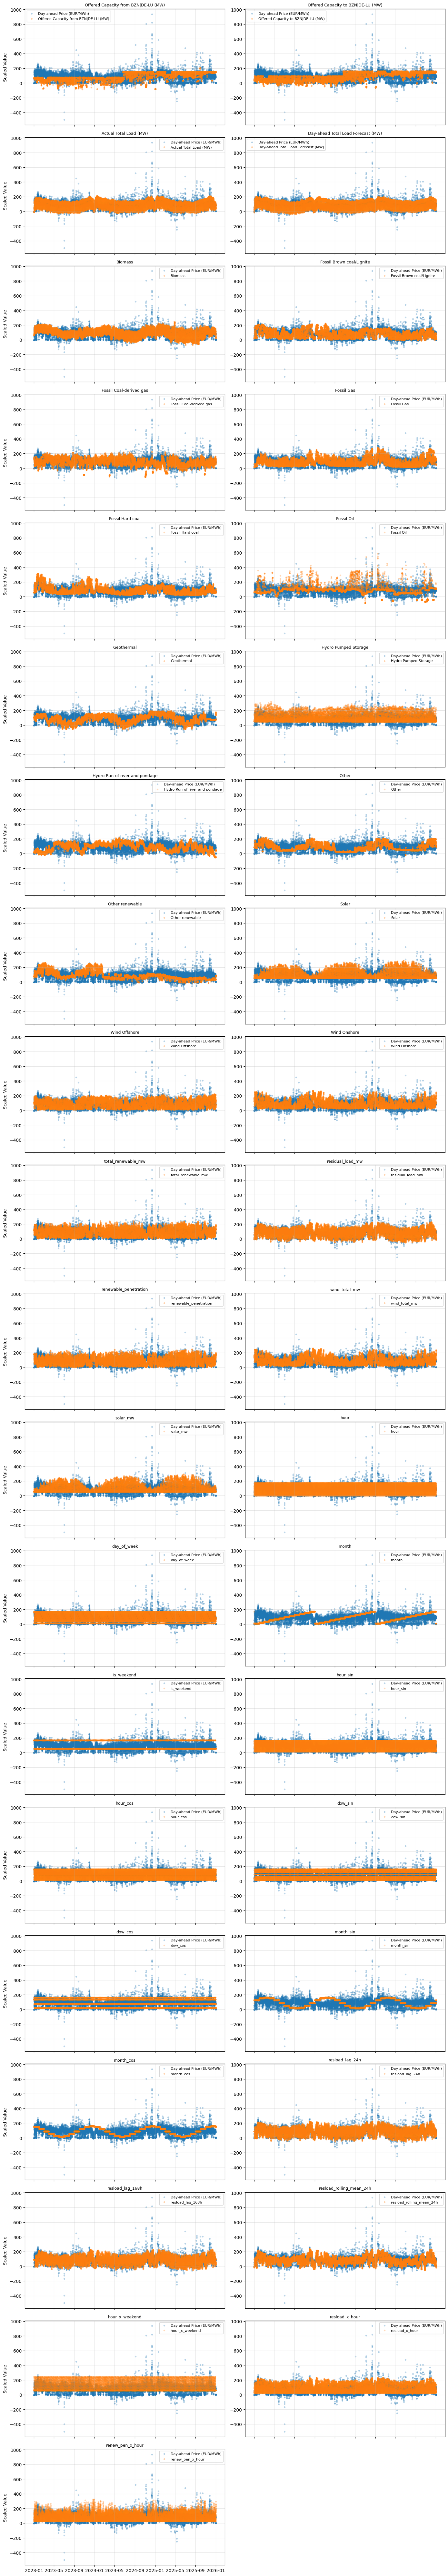

In [38]:
plot_feature_vs_target_timeseries_grid(
    df=df_featured,
    target_col="Day-ahead Price (EUR/MWh)"
)